<a href="https://colab.research.google.com/github/kyalan/DataScienceFactory/blob/master/20200419_imdb_reviews/hub_KerasLayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the TensorBoard notebook extension.
# %load_ext tensorboard
%matplotlib inline

import os, sys
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from datetime import datetime as dt
import sklearn.metrics
import seaborn as sns

from matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
try:
    %tensorflow_version 2.x
except:
    pass

print(tf.__version__)
print(tfds.__version__)

2.2.0-rc3
2.1.0


In [0]:
# Check GPU is avaliable
assert len(tf.config.list_physical_devices('GPU'))==1

# Import data

In [4]:
(ds_train, ds_dev, ds_test), info = tfds.load('imdb_reviews', split=('train[:80%]', 'train[80%:]', 'test')
    # , shuffle_files=True
    , with_info=True, as_supervised=True)
print(info)
n_train, n_dev, n_test = len(list(ds_train)), len(list(ds_dev)), len(list(ds_test))
print('no. of data for train, dev, test', n_train, n_dev, n_test)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete85XY7W/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete85XY7W/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete85XY7W/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew

In [6]:
INPUT_SHAPE = info.features['text'].shape
LABEL_NAMES = info.features['label'].names
N_LABELS = info.features['label'].num_classes
print('INPUT_SHAPE shape:{}'.format(INPUT_SHAPE))
print('LABEL_NAMES:{}'.format(LABEL_NAMES))

INPUT_SHAPE shape:()
LABEL_NAMES:['neg', 'pos']


In [18]:
# check data structure
for txt, label in ds_train.take(1):
    print(txt.numpy().decode())
    print('LABEL: {} - {}'.format(label.numpy(), LABEL_NAMES[label]))

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
LABEL: 0 - neg


In [20]:
for i in range(N_LABELS):
    ds_temp_train = ds_train.filter(lambda img, label: label==i)
    for txt, label in ds_temp_train.take(1):
        print(txt.numpy().decode())
        print('LABEL: {} - {}'.format(label.numpy(), LABEL_NAMES[label]))

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
LABEL: 0 - neg
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. 

# Pre-processing

In [0]:
# ds_train = ds_train.cache().shuffle(n_train).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
# ds_dev = ds_dev.batch(128).cache().prefetch(tf.data.experimental.AUTOTUNE)

ds_train = ds_train.shuffle(n_train).batch(128)
ds_dev = ds_dev.batch(128)

# Modeling

In [0]:
def getModel():
    from tensorflow.keras import Sequential, regularizers
    import tensorflow_hub as hub
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.optimizers import Adam

    # word embedder
    # model list: https://tfhub.dev/s?language=en&module-type=text-embedding
    embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
    hub_layer = hub.KerasLayer(embedding, input_shape=INPUT_SHAPE, dtype=tf.string, trainable=True)

    regularizer = regularizers.l2(0.01)

    model = Sequential()
    model.add(hub_layer)
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizer))
    model.add(Dense(2, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

In [0]:
# Callbacks
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# cb_earlystop = EarlyStopping(patience=10)
# cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                             patience=2, 
#                                             verbose=1, 
#                                             factor=0.5, 
#                                             min_lr=0.00001)

# Tensorboards callback setting
# Clear logs prior to logging data.
# !rm -rf logs

# Create log directory
# logdir = "logs/" + dt.now().strftime("%Y%m%d-%H%M%S")
# cb_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [49]:
%%time

model = getModel()

# %tensorboard --logdir logs
history = model.fit(ds_train, epochs=5, validation_data=ds_dev, verbose=1
                    # , callbacks=[cb_tensorboard]
                    # , callbacks=[cb_earlystop, cb_learning_rate_reduction]
                    )

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_13 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 66        
Total params: 124,646,882
Trainable params: 124,646,882
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
157/157 [==============================] - 20s 126ms/step - loss: 0.6992 - acc: 0.8018 - val_loss: 0.4370 - val_acc: 0.8666
Epoch 2/5
157/157 [==============================] - 20s 125ms/step - loss: 0.2849 - acc: 0.9287 - val_loss: 0.3426 - val_acc: 0.8850
Epoch 3/5
157/157 [==============================] - 20s 125ms/step - loss: 0.1663 - acc: 0.9688 

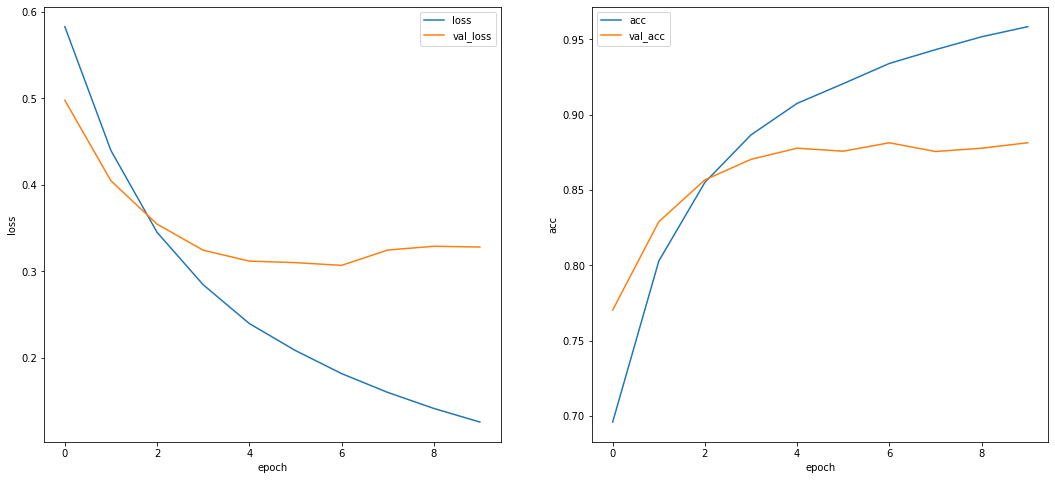

In [34]:
def plot_history(history):
    hist = history.history
    fig = plt.figure(figsize=(18, 8))
    iplot = 0
    for key in ['loss', 'acc']:
        iplot += 1
        fig.add_subplot(1, 2, iplot)
        plt.xlabel('epoch')
        plt.ylabel(key)
        plt.plot(range(len(hist[key])), hist[key], label = key)
        plt.plot(range(len(hist['val_' + key])), hist['val_' + key], label = 'val_' + key)
        plt.legend()
    plt.show()

plot_history(history)

# Model Evaluation

In [35]:
eval = model.evaluate(ds_test.batch(128))
print('Test data: Loss = {}, Accuracy = {}'.format(eval[0], eval[1]))
print('Right Prediction: {}, Wrong Prediction: {}'.format(eval[1]*n_test, (1.0-eval[1])*n_test))

196/196 [==============================] - 3s 15ms/step - loss: 0.3290 - acc: 0.8680
Test data: Loss = 0.3290070593357086, Accuracy = 0.8680400252342224
Right Prediction: 21701.00063085556, Wrong Prediction: 3298.9993691444397


In [36]:
%%time

test_labels = np.array(next(iter(ds_test.batch(n_test).take(1)))[1])
test_pred = model.predict(ds_test.batch(128)).argmax(axis=1)

CPU times: user 8.9 s, sys: 5.32 s, total: 14.2 s
Wall time: 4.78 s


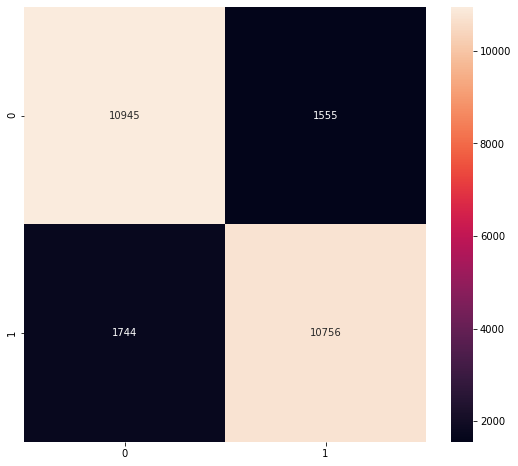

In [37]:
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
fig = plt.figure(figsize=(9, 8))
sns.heatmap(pd.DataFrame(cm, range(N_LABELS), range(N_LABELS)), annot=True, fmt='d')

In [39]:
nrows, ncols = 2, 5

itxts = np.where(test_labels!=test_pred)[0]
for i in range(10):
    itxt = itxts[i]
    for txt, label in ds_test.skip(itxt).take(1):
        print(txt.numpy().decode())
        print('PREDICT: {} - {} ; LABEL: {} - {}'.format(test_pred[itxt], LABEL_NAMES[test_pred[itxt]], label.numpy(), LABEL_NAMES[label]))        

As long as you keep in mind that the production of this movie was a copyright ploy, and not intended as a serious release, it is actually surprising how not absolutely horrible it is. I even liked the theme music.<br /><br />And if ever a flick cried out for a treatment by Joel (or Mike) and the MST3K Bots, this is it! Watch this with a bunch of smart-ass wise-crackers, and you're in for a good time. Have a brew, butter up some large pretzels, and enjoy.<br /><br />Of course, obtaining a copy requires buying a bootleg or downloading it as shareware, but if you're here on the IMDb, then you're most likely savvy enough to do so. Good luck.<br /><br />And look for my favorite part....where Dr. Doom informs the FF that they have 12 hours to comply with his wishes....and he actually gestures the number "12" with his finger while doing so....it's like "Evil Sesame Street"....hoo boy.<br /><br />...and of course Mrs. Storm declaring "Just look at you....the Fanstastic Four" is just so heartwa